# Packages

In [1]:
import sys

sys.path.append("./myutils")
from data_generator import (
    DataGeneratorParam,
    TrainDataParam,
    RealDataParam,
    ExpandedDataParam,
    DataGenerator,
)
from train_rhat import train_rhat
from r0_CI import construct_r0_CIs
from true_models import generate_true_models, generate_bias_models
from learner import build_learner
from utils import get_model_directory_uri
from CI_plots import plot_CI_by_conditions
import itertools
import numpy as np
import pandas as pd
from multiprocessing.dummy import Pool as ThreadPool
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="You are using `torch.load` with `weights_only=False`",
    category=FutureWarning
)

# All parameters

In [3]:
Q = 100  # Z in R^Q
P = 100  # X in R^P
# Y in R
OUTPUT_DIRECTORY_URI = "./results"

In [4]:
r0, g0, f0 = generate_true_models(Q, P)
DATA_GENERATOR_PARAM = DataGeneratorParam(p=P, q=Q, r0=r0, g0=g0, f0=f0)

TRAIN_DATA_PARAM = TrainDataParam(n_train=50000)

In [ ]:
r0_LEARNERS = {
    # "linear": build_learner(model_type='ols'),
    "kernel": build_learner(model_type="krr"),
    "xgboost": build_learner(model_type="xgb", output_dim=P),
    "neural_net_128x128_1500_64": build_learner(
        model_type="mlp",
        input_dim=P,
        output_dim=Q,
        hidden_layers=[128, 128],
        epochs=1500,
        batch_size=64,
    ),
    # "random_forest": build_learner(
    #     model_type="rf",
    #     output_dim=P,
    #     max_features="sqrt",
    # ),
    "random_forest_20dep_100ests": build_learner(
        model_type="rf",
        output_dim=P,
        max_depth=20,
        n_estimators=100,
        max_features="sqrt",
    ),
    # "random_forest_40dep_100ests": build_learner(
    #     model_type="rf",
    #     output_dim=P,
    #     max_depth=40,
    #     n_estimators=100,
    #     max_features="sqrt",
    # ),
}

In [ ]:
nn_bias_1, nn_bias_2 = generate_bias_models(Q, P)
BIAS_FUNCS = [nn_bias_1, nn_bias_2]
BIAS_SCALES = [0, 1, 10]
N_REALS = [100, 300, 500, 700, 1000]
R_EXPANDEDS = [0.001, 0.01, 0.1]

REAL_DATA_PARAMS = [
    RealDataParam(bias_func=bias_func, bias_scale=bias_scale, n_real=n_real)
    for bias_func, bias_scale, n_real in itertools.product(
        BIAS_FUNCS, BIAS_SCALES, N_REALS
    )
]
print("Number of real data param combos:", len(REAL_DATA_PARAMS))

EXPANDED_DATA_PARAMS = [
    ExpandedDataParam(n_expanded=10 * n_real, r_expanded=r)
    for n_real, r in itertools.product(N_REALS, R_EXPANDEDS)
]
print("Number of expanded data param combos:", len(EXPANDED_DATA_PARAMS))

Number of real data param combos: 12
Number of expanded data param combos: 6


In [7]:
combinations = list(
    itertools.product(r0_LEARNERS.items(), REAL_DATA_PARAMS, EXPANDED_DATA_PARAMS)
)
print(f"There are {len(combinations)} combinations to run.")

There are 288 combinations to run.


# Train/Retrieve models

In [8]:
def train_single_model(args):
    learner_name, learner = args
    model_directory_uri = get_model_directory_uri(
        data_generator_param=DATA_GENERATOR_PARAM,
        train_data_param=TRAIN_DATA_PARAM,
        r0_learner_name=learner_name,
        output_directory_uri=OUTPUT_DIRECTORY_URI,
    )
    rhat = train_rhat(
        data_generator_param=DATA_GENERATOR_PARAM,
        train_data_param=TRAIN_DATA_PARAM,
        model_directory_uri=model_directory_uri,
        learner_name=learner_name,
        learner=learner,
        fresh=False,
    )
    return model_directory_uri, rhat

In [9]:
trained_models = {}

with ProcessPoolExecutor() as executor:
    futures = {
        executor.submit(train_single_model, item): item[0]  # learner_name
        for item in r0_LEARNERS.items()
    }
    for future in tqdm(as_completed(futures), total=len(futures), desc="Training Models"):
        learner_name = futures[future]
        model_directory_uri, rhat = future.result()
        trained_models[learner_name] = (model_directory_uri, rhat)

Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

Reading rhat...

Reading rhat...

Reading rhat...

Reading rhat...

kernel training MSE = 6039.233176466542
'train_rhat' executed in 0.687346s


Training Models:  25%|██▌       | 1/4 [00:00<00:02,  1.41it/s]

xgboost training MSE = 2670.9454665857
'train_rhat' executed in 1.642188s


Training Models:  50%|█████     | 2/4 [00:02<00:02,  1.46s/it]

neural_net_128x128_1500_64 training MSE = 1.1814813298133593
'train_rhat' executed in 6.662652s


Training Models:  75%|███████▌  | 3/4 [00:08<00:03,  3.27s/it]

random_forest training MSE = 1533.9805656345964
'train_rhat' executed in 54.703120s


Training Models: 100%|██████████| 4/4 [03:03<00:00, 45.76s/it]


# Construct/Retrieve r0_CIs


In [10]:
def run_single_experiment(
    r0_learner_name,
    model_directory_uri,
    rhat,
    data_generator_param,
    real_data_param,
    expanded_data_param,
    r0,
    fresh=False,
):
    r0_CIs, coverage, avg_me = construct_r0_CIs(
        data_generator_param=data_generator_param,
        real_data_param=real_data_param,
        expanded_data_param=expanded_data_param,
        model_directory_uri=model_directory_uri,
        rhat=rhat,
        r0=r0,
        fresh=fresh,
    )

    return {
        "r0_learner_name": r0_learner_name,
        "bias_func": real_data_param.bias_func.__class__.__name__,
        "bias_scale": real_data_param.bias_scale,
        "n_real": real_data_param.n_real,
        "n_expanded": expanded_data_param.n_expanded,
        "r_expanded": expanded_data_param.r_expanded,
        "coverage": coverage,
        "avg_me": avg_me,
    }

In [11]:
def run_combination(args):
    (r0_learner_name, _), real_data_param, expanded_data_param = args
    model_directory_uri, rhat = trained_models[r0_learner_name]
    
    # print(f"Running {r0_learner_name}, bias={real_data_param.bias_scale}, r={expanded_data_param.r_expanded}")
    return run_single_experiment(
        r0_learner_name=r0_learner_name,
        model_directory_uri=model_directory_uri,
        rhat=rhat,
        data_generator_param=DATA_GENERATOR_PARAM,
        real_data_param=real_data_param,
        expanded_data_param=expanded_data_param,
        r0=r0,
        fresh=False,
    )

In [12]:
results = []
with ThreadPool() as pool:
    for result in tqdm(pool.imap_unordered(run_combination, combinations, chunksize=1), total=len(combinations)):
        results.append(result)

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 1/288 [00:00<00:52,  5.42it/s]

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 C

  2%|▏         | 6/288 [00:00<00:22, 12.73it/s]

Coverage: 0.165
Average ME: 8.868
'construct_r0_CIs' executed in 0.293416s
Coverage: 0.389
Average ME: 26.508
'construct_r0_CIs' executed in 0.342381s
Coverage: 0.389
Average ME: 26.508
'construct_r0_CIs' executed in 0.363294s
Coverage: 0.389
Average ME: 26.508
'construct_r0_CIs' executed in 0.366883s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.403
Average ME: 85.920
'construct_r0_CIs' executed in 0.471846s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.103
Average ME: 8.458
'construct_r0_CIs' executed in 0.513394s
Coverage: 0.389
Average ME: 26.508
'construct_r0_CIs' executed in 0.563518s
Reading r0 CIs...

Coverage: 0.403
Average ME: 85.920
'construct_r0_CIs' executed in 0.598883s
Coverage: 0.104
Average ME: 8.458
'construct_r0_CIs' executed in 0.627160s


  3%|▎         | 10/288 [00:00<00:21, 12.70it/s]

Reading r0 CIs...

Coverage: 0.103
Average ME: 8.458
'construct_r0_CIs' executed in 0.742613s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.371
Average ME: 27.790
'construct_r0_CIs' executed in 0.841735s
Coverage: 0.371
Average ME: 27.790
'construct_r0_CIs' executed in 0.842105s
Coverage: 0.371
Average ME: 27.790
'construct_r0_CIs' executed in 1.156708s
Coverage: 0.095
Average ME: 27.370
'construct_r0_CIs' executed in 1.181520s
Coverage: 0.388
Average ME: 26.508
'construct_r0_CIs' executed in 1.234654s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.371
Average ME: 27.790
'construct_r0_CIs' executed in 1.261382s
Coverage: 0.165
Average ME: 8.867
'construct_r0_CIs' executed in 1.276680s
Coverage: 0.389
Average ME: 26.508
'construct_r0_CIs' executed in 1.295181s
Reading r0 CIs...

Coverage: 0.371
Average ME: 27.790
'construct_r0_CIs' executed in 1.290393s
Coverage: 0.095
Average ME: 27.370
'construct_r0_CIs' executed in 1.283139s
Reading r0 CIs...

Reading r0 CIs...



  9%|▊         | 25/288 [00:01<00:12, 21.40it/s]

Reading r0 CIs...

Coverage: 0.095
Average ME: 27.370
'construct_r0_CIs' executed in 1.343124s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.371
Average ME: 27.790
'construct_r0_CIs' executed in 1.398888s
Reading r0 CIs...

Coverage: 0.095
Average ME: 27.370
'construct_r0_CIs' executed in 1.422044s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.165
Average ME: 8.867
'construct_r0_CIs' executed in 1.498560s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.103
Average ME: 8.458
'construct_r0_CIs' executed in 1.582450s


 12%|█▏        | 35/288 [00:02<00:10, 23.20it/s]

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.095
Average ME: 27.370
'construct_r0_CIs' executed in 1.603685s
Coverage: 0.103
Average ME: 8.458
'construct_r0_CIs' executed in 1.631140s
Reading r0 CIs...

Coverage: 0.165
Average ME: 8.867
'construct_r0_CIs' executed in 1.733364s
Reading r0 CIs...

Coverage: 0.389
Average ME: 26.508
'construct_r0_CIs' executed in 1.754543s
Coverage: 0.340
Average ME: 34.894
'construct_r0_CIs' executed in 1.726281s
Coverage: 0.165
Average ME: 8.867
'construct_r0_CIs' executed in 1.796116s
Reading r0 CIs...

Coverage: 0.403
Average ME: 85.920
'construct_r0_CIs' executed in 1.845827s
Reading r0 CIs...

Coverage: 0.165
Average ME: 8.867
'construct_r0_CIs' executed in 1.874698s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.095
Average ME: 27.370
'construct_r0_CIs' executed in 1.929308s
Reading r0 CIs...

Coverage: 0.103
Average ME: 8.458
'construct_r0_CIs' executed in 1.916054s
Coverage: 0.403
Average ME: 85.920
'construct_r0_CIs' executed in 1.955329

 15%|█▍        | 42/288 [00:02<00:11, 21.73it/s]

Reading r0 CIs...

Coverage: 0.403
Average ME: 85.920
'construct_r0_CIs' executed in 2.126124s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.340
Average ME: 34.894
'construct_r0_CIs' executed in 2.076815s
Coverage: 0.389
Average ME: 26.508
'construct_r0_CIs' executed in 2.112214s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.103
Average ME: 8.458
'construct_r0_CIs' executed in 2.115485s
Coverage: 0.104
Average ME: 8.458
'construct_r0_CIs' executed in 2.118713s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.128
Average ME: 11.132
'construct_r0_CIs' executed in 2.248407s
Coverage: 0.103
Average ME: 8.458
'construct_r0_CIs' executed in 2.299520s
Coverage: 0.340
Average ME: 34.894
'construct_r0_CIs' executed in 2.320641s


 18%|█▊        | 51/288 [00:02<00:12, 18.64it/s]

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.389
Average ME: 26.508
'construct_r0_CIs' executed in 2.656297s
Coverage: 0.403
Average ME: 85.920
'construct_r0_CIs' executed in 2.686858s
Coverage: 0.127
Average ME: 11.131
'construct_r0_CIs' executed in 2.631847s
Reading r0 CIs...

Coverage: 0.103
Average ME: 8.458
'construct_r0_CIs' executed in 2.685105s
Reading r0 CIs...

Coverage: 0.340
Average ME: 34.894
'construct_r0_CIs' executed in 2.700025s
Reading r0 CIs...

Coverage: 0.389
Average ME: 26.508
'construct_r0_CIs' executed in 2.826902s
Coverage: 0.340
Average ME: 34.894
'construct_r0_CIs' executed in 2.815142s
Coverage: 0.127
Average ME: 11.131
'construct_r0_CIs' executed in 2.798219s
Coverage: 0.389
Average ME: 26.508
'construct_r0_CIs' executed in 2.853181s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.219
Average ME: 222.484
'construct_r0_CIs' executed in 2.908065s


 22%|██▏       | 63/288 [00:03<00:07, 30.86it/s]

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.127
Average ME: 11.131
'construct_r0_CIs' executed in 2.937462s
Reading r0 CIs...

Coverage: 0.103
Average ME: 8.458
'construct_r0_CIs' executed in 2.982256s
Coverage: 0.127
Average ME: 11.131
'construct_r0_CIs' executed in 2.955852s
Coverage: 0.340
Average ME: 34.894
'construct_r0_CIs' executed in 2.993467s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.219
Average ME: 222.484
'construct_r0_CIs' executed in 3.021910s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.128
Average ME: 11.132
'construct_r0_CIs' executed in 3.058490s
Coverage: 0.218
Average ME: 222.484
'construct_r0_CIs' executed in 3.086828s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.413
Average ME: 28.081
'construct_r0_CIs' executed in 2.695894s
Coverage: 0.062
Average ME: 70.949
'construct_r0_CIs' executed in 2.815255s
Coverage: 0.219
Average ME: 222.484
'construct_r0_CIs' executed in 3.252906s
Reading r0

 24%|██▍       | 70/288 [00:03<00:11, 18.71it/s]

Coverage: 0.062
Average ME: 70.949
'construct_r0_CIs' executed in 3.227091s
Coverage: 0.219
Average ME: 222.484
'construct_r0_CIs' executed in 3.397243s
Coverage: 0.219
Average ME: 222.484
'construct_r0_CIs' executed in 3.303286s
Coverage: 0.112
Average ME: 8.962
'construct_r0_CIs' executed in 2.446817s
Reading r0 CIs...

Coverage: 0.062
Average ME: 70.949
'construct_r0_CIs' executed in 3.392861s
Coverage: 0.062
Average ME: 70.949
'construct_r0_CIs' executed in 3.452195s
Coverage: 0.110
Average ME: 8.961
'construct_r0_CIs' executed in 2.516288s
Coverage: 0.108
Average ME: 8.958
'construct_r0_CIs' executed in 2.607969s


 26%|██▌       | 74/288 [00:03<00:10, 20.69it/s]

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.416
Average ME: 28.080
'construct_r0_CIs' executed in 3.330867s
Coverage: 0.108
Average ME: 8.958
'construct_r0_CIs' executed in 2.672854s
Reading r0 CIs...

Coverage: 0.437
Average ME: 86.241
'construct_r0_CIs' executed in 2.125903s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.397
Average ME: 29.250
'construct_r0_CIs' executed in 2.603317s


 30%|██▉       | 85/288 [00:04<00:06, 29.53it/s]

Reading r0 CIs...

Coverage: 0.413
Average ME: 28.080
'construct_r0_CIs' executed in 3.221259s
Coverage: 0.111
Average ME: 8.990
'construct_r0_CIs' executed in 2.814175s
Coverage: 0.411
Average ME: 29.242
'construct_r0_CIs' executed in 2.722136s
Reading r0 CIs...

Coverage: 0.431
Average ME: 86.241
'construct_r0_CIs' executed in 2.013639s
Reading r0 CIs...

Coverage: 0.417
Average ME: 29.240
'construct_r0_CIs' executed in 2.834568s
Coverage: 0.062
Average ME: 70.949
'construct_r0_CIs' executed in 3.684836s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.404
Average ME: 28.081
'construct_r0_CIs' executed in 3.053245s
Reading r0 CIs...

Reading r0 CIs...



 31%|███       | 89/288 [00:04<00:11, 17.01it/s]

Reading r0 CIs...

Coverage: 0.405
Average ME: 28.090
'construct_r0_CIs' executed in 3.850646s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.111
Average ME: 9.333
'construct_r0_CIs' executed in 3.027787s
Coverage: 0.431
Average ME: 86.244
'construct_r0_CIs' executed in 2.705083s
Reading r0 CIs...

Coverage: 0.112
Average ME: 8.958
'construct_r0_CIs' executed in 3.427389s
Coverage: 0.115
Average ME: 9.360
'construct_r0_CIs' executed in 3.010115s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.436
Average ME: 86.241
'construct_r0_CIs' executed in 2.876280s
Coverage: 0.155
Average ME: 27.475
'construct_r0_CIs' executed in 2.616065s
Coverage: 0.115
Average ME: 9.332
'construct_r0_CIs' executed in 2.961221s
Reading r0 CIs...

Coverage: 0.112
Average ME: 9.329
'construct_r0_CIs' executed in 2.991484s
Reading r0 CIs...

Reading r0 CIs...



 35%|███▍      | 100/288 [00:05<00:09, 20.77it/s]

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.436
Average ME: 86.241
'construct_r0_CIs' executed in 2.911686s
Reading r0 CIs...

Coverage: 0.413
Average ME: 28.080
'construct_r0_CIs' executed in 2.203091s
Reading r0 CIs...

Coverage: 0.411
Average ME: 29.240
'construct_r0_CIs' executed in 3.481426s
Coverage: 0.413
Average ME: 28.081
'construct_r0_CIs' executed in 2.630366s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.397
Average ME: 29.241
'construct_r0_CIs' executed in 3.528624s
Coverage: 0.417
Average ME: 29.240
'construct_r0_CIs' executed in 3.660861s
Coverage: 0.405
Average ME: 28.090
'construct_r0_CIs' executed in 2.412013s
Coverage: 0.112
Average ME: 9.329
'construct_r0_CIs' executed in 3.524230s
Coverage: 0.152
Average ME: 27.474
'construct_r0_CIs' executed in 3.019208s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...



 38%|███▊      | 108/288 [00:05<00:07, 23.43it/s]

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.437
Average ME: 86.241
'construct_r0_CIs' executed in 3.292993s
Coverage: 0.145
Average ME: 27.485
'construct_r0_CIs' executed in 3.125238s
Reading r0 CIs...

Coverage: 0.404
Average ME: 28.081
'construct_r0_CIs' executed in 2.567413s
Reading r0 CIs...

Coverage: 0.108
Average ME: 8.958
'construct_r0_CIs' executed in 2.563103s
Coverage: 0.111
Average ME: 9.329
'construct_r0_CIs' executed in 3.546041s
Coverage: 0.155
Average ME: 27.474
'construct_r0_CIs' executed in 3.204419s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.152
Average ME: 27.474
'construct_r0_CIs' executed in 3.284331s


 39%|███▉      | 112/288 [00:05<00:06, 25.82it/s]

Reading r0 CIs...

Coverage: 0.112
Average ME: 8.958
'construct_r0_CIs' executed in 2.590680s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.145
Average ME: 27.475
'construct_r0_CIs' executed in 3.305621s
Coverage: 0.416
Average ME: 28.080
'construct_r0_CIs' executed in 3.290108s


 43%|████▎     | 123/288 [00:05<00:06, 27.12it/s]

Coverage: 0.308
Average ME: 36.116
'construct_r0_CIs' executed in 2.615905s
Coverage: 0.112
Average ME: 8.962
'construct_r0_CIs' executed in 2.858417s
Coverage: 0.108
Average ME: 8.958
'construct_r0_CIs' executed in 2.861243s
Coverage: 0.315
Average ME: 36.116
'construct_r0_CIs' executed in 2.677839s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.416
Average ME: 28.080
'construct_r0_CIs' executed in 3.070591s
Coverage: 0.111
Average ME: 8.990
'construct_r0_CIs' executed in 2.910248s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.316
Average ME: 36.125
'construct_r0_CIs' executed in 2.776914s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.316
Average ME: 36.117
'construct_r0_CIs' executed in 2.753126s
Reading r0 CIs...

Coverage: 0.315
Average ME: 36.116
'construct_r0_CIs' executed in 2.919453s
Reading r0 CIs...



 44%|████▍     | 127/288 [00:06<00:06, 25.42it/s]

Coverage: 0.110
Average ME: 8.961
'construct_r0_CIs' executed in 2.970301s
Coverage: 0.308
Average ME: 36.118
'construct_r0_CIs' executed in 2.946161s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.109
Average ME: 11.545
'construct_r0_CIs' executed in 2.751323s
Coverage: 0.123
Average ME: 11.519
'construct_r0_CIs' executed in 2.901256s
Reading r0 CIs...

Coverage: 0.224
Average ME: 222.671
'construct_r0_CIs' executed in 2.573696s


 45%|████▌     | 130/288 [00:06<00:08, 19.36it/s]

Reading r0 CIs...

Coverage: 0.122
Average ME: 11.523
'construct_r0_CIs' executed in 3.055627s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.123
Average ME: 11.519
'construct_r0_CIs' executed in 3.139980s
Coverage: 0.226
Average ME: 222.671
'construct_r0_CIs' executed in 2.705562s
Coverage: 0.547
Average ME: 0.222
'construct_r0_CIs' executed in 1.906087s


 47%|████▋     | 136/288 [00:06<00:07, 19.21it/s]

Reading r0 CIs...

Coverage: 0.759
Average ME: 0.371
'construct_r0_CIs' executed in 2.481280s
Coverage: 0.122
Average ME: 11.519
'construct_r0_CIs' executed in 3.243471s
Coverage: 0.226
Average ME: 222.672
'construct_r0_CIs' executed in 3.082467s
Reading r0 CIs...

Coverage: 0.108
Average ME: 11.521
'construct_r0_CIs' executed in 3.280904s
Reading r0 CIs...

Coverage: 0.061
Average ME: 71.006
'construct_r0_CIs' executed in 2.863800s


 51%|█████     | 146/288 [00:07<00:06, 21.27it/s]

Coverage: 0.061
Average ME: 71.006
'construct_r0_CIs' executed in 2.939725s
Reading r0 CIs...

Coverage: 0.058
Average ME: 71.011
'construct_r0_CIs' executed in 3.011749s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.061
Average ME: 71.006
'construct_r0_CIs' executed in 3.213155s
Reading r0 CIs...

Coverage: 0.224
Average ME: 222.670
'construct_r0_CIs' executed in 3.425210s
Coverage: 0.061
Average ME: 71.006
'construct_r0_CIs' executed in 3.298454s
Coverage: 0.754
Average ME: 0.366
'construct_r0_CIs' executed in 2.997774s
Reading r0 CIs...

Coverage: 0.807
Average ME: 0.414
'construct_r0_CIs' executed in 3.079640s
Coverage: 0.438
Average ME: 8.162
'construct_r0_CIs' executed in 2.418352s
Reading r0 CIs...

Coverage: 0.405
Average ME: 0.131
'construct_r0_CIs' executed in 2.452345s
Coverage: 0.373
Average ME: 0.117
'construct_r0_CIs' executed in 2.988008s
Reading r0 CIs...

Coverage: 0.438
Average ME: 8.160
'construct_r0_CIs' executed in 2.442768s
Coverage: 0.753
Average ME: 0.366
'c

 58%|█████▊    | 168/288 [00:08<00:03, 30.01it/s]

Coverage: 0.438
Average ME: 8.160
'construct_r0_CIs' executed in 2.513519s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.142
Average ME: 2.599
'construct_r0_CIs' executed in 2.338757s
Reading r0 CIs...

Coverage: 0.224
Average ME: 222.670
'construct_r0_CIs' executed in 3.746037s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.058
Average ME: 71.006
'construct_r0_CIs' executed in 3.573009s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.754
Average ME: 0.366
'construct_r0_CIs' executed in 3.553109s
Coverage: 0.374
Average ME: 0.117
'construct_r0_CIs' executed in 2.913796s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.438
Average ME: 8.160
'construct_r0_CIs' executed in 3.168354s
Coverage: 0.436
Average ME: 81.526
'construct_r0_CIs' executed in 2.675742s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.753
Average ME: 0.366
'construct_r0_CIs' executed in 3.889312s
Reading r0 CIs...

Coverage: 0.377
A

 60%|██████    | 174/288 [00:08<00:04, 28.33it/s]

Coverage: 0.142
Average ME: 2.598
'construct_r0_CIs' executed in 3.266523s
Coverage: 0.143
Average ME: 2.606
'construct_r0_CIs' executed in 3.146794s
Reading r0 CIs...

Coverage: 0.436
Average ME: 81.526
'construct_r0_CIs' executed in 2.922813s
Coverage: 0.142
Average ME: 2.598
'construct_r0_CIs' executed in 3.175887s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.151
Average ME: 25.959
'construct_r0_CIs' executed in 2.624534s
Coverage: 0.753
Average ME: 0.366
'construct_r0_CIs' executed in 2.628788s
Coverage: 0.151
Average ME: 25.959
'construct_r0_CIs' executed in 2.755724s
Coverage: 0.436
Average ME: 81.526
'construct_r0_CIs' executed in 3.111256s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.151
Average ME: 25.960
'construct_r0_CIs' executed in 2.961118s
Reading r0 CIs...

Reading r0 CIs...



 62%|██████▏   | 179/288 [00:08<00:03, 27.37it/s]

Coverage: 0.436
Average ME: 81.526
'construct_r0_CIs' executed in 3.270905s
Coverage: 0.373
Average ME: 0.117
'construct_r0_CIs' executed in 2.589761s
Coverage: 0.142
Average ME: 2.598
'construct_r0_CIs' executed in 3.582904s
Reading r0 CIs...

Coverage: 0.754
Average ME: 0.366
'construct_r0_CIs' executed in 2.909330s
Reading r0 CIs...

Coverage: 0.151
Average ME: 25.959
'construct_r0_CIs' executed in 3.266049s
Reading r0 CIs...

Coverage: 0.753
Average ME: 0.366
'construct_r0_CIs' executed in 2.968964s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.151
Average ME: 25.959
'construct_r0_CIs' executed in 3.113780s


 65%|██████▌   | 188/288 [00:08<00:03, 25.21it/s]

Reading r0 CIs...

Coverage: 0.759
Average ME: 0.371
'construct_r0_CIs' executed in 3.108817s
Reading r0 CIs...

Coverage: 0.807
Average ME: 0.414
'construct_r0_CIs' executed in 3.204077s
Reading r0 CIs...

Coverage: 0.374
Average ME: 0.117
'construct_r0_CIs' executed in 2.891566s
Coverage: 0.373
Average ME: 0.117
'construct_r0_CIs' executed in 3.071971s
Reading r0 CIs...

Coverage: 0.754
Average ME: 0.366
'construct_r0_CIs' executed in 3.195717s
Reading r0 CIs...

Coverage: 0.405
Average ME: 0.131
'construct_r0_CIs' executed in 2.900961s
Reading r0 CIs...

Coverage: 0.229
Average ME: 22.083
'construct_r0_CIs' executed in 2.896445s


 67%|██████▋   | 193/288 [00:09<00:03, 27.06it/s]

Reading r0 CIs...

Coverage: 0.377
Average ME: 0.118
'construct_r0_CIs' executed in 3.132629s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.547
Average ME: 0.222
'construct_r0_CIs' executed in 3.152507s
Reading r0 CIs...

Coverage: 0.229
Average ME: 22.083
'construct_r0_CIs' executed in 2.636341s
Coverage: 0.229
Average ME: 22.083
'construct_r0_CIs' executed in 2.562149s
Reading r0 CIs...



 68%|██████▊   | 197/288 [00:09<00:04, 22.61it/s]

Coverage: 0.229
Average ME: 22.083
'construct_r0_CIs' executed in 2.977892s
Coverage: 0.229
Average ME: 22.084
'construct_r0_CIs' executed in 2.878261s
Coverage: 0.229
Average ME: 22.083
'construct_r0_CIs' executed in 2.904906s
Coverage: 0.080
Average ME: 7.042
'construct_r0_CIs' executed in 2.754279s
Reading r0 CIs...

Coverage: 0.080
Average ME: 7.042
'construct_r0_CIs' executed in 2.513029s
Coverage: 0.080
Average ME: 70.405
'construct_r0_CIs' executed in 2.266995s
Coverage: 0.080
Average ME: 7.042
'construct_r0_CIs' executed in 2.880171s
Coverage: 0.080
Average ME: 7.042
'construct_r0_CIs' executed in 2.658414s


 71%|███████   | 205/288 [00:10<00:05, 16.04it/s]

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.080
Average ME: 7.042
'construct_r0_CIs' executed in 2.982638s
Reading r0 CIs...

Coverage: 0.293
Average ME: 35.389
'construct_r0_CIs' executed in 2.491699s
Coverage: 0.080
Average ME: 70.405
'construct_r0_CIs' executed in 2.732802s
Reading r0 CIs...

Coverage: 0.080
Average ME: 7.045
'construct_r0_CIs' executed in 3.272683s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.230
Average ME: 220.793
'construct_r0_CIs' executed in 2.927857s
Coverage: 0.080
Average ME: 70.405
'construct_r0_CIs' executed in 2.839297s


 73%|███████▎  | 210/288 [00:10<00:04, 18.13it/s]

Reading r0 CIs...

Coverage: 0.286
Average ME: 36.231
'construct_r0_CIs' executed in 2.012467s
Reading r0 CIs...

Coverage: 0.292
Average ME: 35.388
'construct_r0_CIs' executed in 2.698526s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.230
Average ME: 220.793
'construct_r0_CIs' executed in 3.230997s
Coverage: 0.293
Average ME: 35.388
'construct_r0_CIs' executed in 2.683968s
Reading r0 CIs...

Coverage: 0.286
Average ME: 36.231
'construct_r0_CIs' executed in 2.246578s
Reading r0 CIs...

Coverage: 0.075
Average ME: 11.299
'construct_r0_CIs' executed in 2.645324s
Reading r0 CIs...



 76%|███████▌  | 218/288 [00:10<00:03, 22.89it/s]

Coverage: 0.230
Average ME: 220.793
'construct_r0_CIs' executed in 3.241658s
Coverage: 0.293
Average ME: 35.389
'construct_r0_CIs' executed in 2.762724s
Coverage: 0.076
Average ME: 11.303
'construct_r0_CIs' executed in 2.474125s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.080
Average ME: 70.405
'construct_r0_CIs' executed in 3.274285s
Coverage: 0.230
Average ME: 220.793
'construct_r0_CIs' executed in 3.417175s
Coverage: 0.080
Average ME: 70.405
'construct_r0_CIs' executed in 3.204499s
Coverage: 0.281
Average ME: 36.232
'construct_r0_CIs' executed in 2.517781s
Coverage: 0.080
Average ME: 70.405
'construct_r0_CIs' executed in 3.384948s
Coverage: 0.075
Average ME: 11.300
'construct_r0_CIs' executed in 2.651229s


 78%|███████▊  | 224/288 [00:10<00:03, 18.06it/s]

Coverage: 0.230
Average ME: 220.793
'construct_r0_CIs' executed in 3.525876s
Reading r0 CIs...

Coverage: 0.292
Average ME: 35.388
'construct_r0_CIs' executed in 3.433052s
Coverage: 0.076
Average ME: 11.300
'construct_r0_CIs' executed in 2.869327s
Coverage: 0.090
Average ME: 11.572
'construct_r0_CIs' executed in 2.470755s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.293
Average ME: 35.390
'construct_r0_CIs' executed in 3.339221s
Coverage: 0.230
Average ME: 220.793
'construct_r0_CIs' executed in 3.653150s
Reading r0 CIs...

Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.075
Average ME: 11.299
'construct_r0_CIs' executed in 2.914334s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.287
Average ME: 36.231
'construct_r0_CIs' executed in 2.865440s
Coverage: 0.287
Average ME: 36.231
'construct_r0_CIs' executed in 2.656382s
Coverage: 0.086
Average ME: 11.569
'construct_r0_CIs' executed in 2.677004s
Reading r0 CIs...

Reading r0 CIs...

Coverage: 0.366
Average ME: 88.625
'construct_r0

 85%|████████▍ | 244/288 [00:11<00:01, 23.77it/s]

Coverage: 0.077
Average ME: 11.299
'construct_r0_CIs' executed in 3.346789s
Coverage: 0.086
Average ME: 11.568
'construct_r0_CIs' executed in 3.052755s
Coverage: 0.366
Average ME: 88.625
'construct_r0_CIs' executed in 2.778895s
Coverage: 0.281
Average ME: 36.231
'construct_r0_CIs' executed in 3.181647s
Coverage: 0.366
Average ME: 88.625
'construct_r0_CIs' executed in 2.976540s
Coverage: 0.086
Average ME: 11.568
'construct_r0_CIs' executed in 3.129146s
Coverage: 0.366
Average ME: 88.625
'construct_r0_CIs' executed in 2.971276s
Coverage: 0.367
Average ME: 88.625
'construct_r0_CIs' executed in 3.044214s
Coverage: 0.110
Average ME: 28.238
'construct_r0_CIs' executed in 2.865021s


 87%|████████▋ | 251/288 [00:11<00:01, 23.41it/s]

Coverage: 0.109
Average ME: 28.237
'construct_r0_CIs' executed in 2.730829s
Coverage: 0.112
Average ME: 28.238
'construct_r0_CIs' executed in 2.755241s
Coverage: 0.109
Average ME: 28.237
'construct_r0_CIs' executed in 3.006682s
Coverage: 0.292
Average ME: 35.388
'construct_r0_CIs' executed in 2.783017s
Coverage: 0.293
Average ME: 35.389
'construct_r0_CIs' executed in 2.914910s
Coverage: 0.293
Average ME: 35.390
'construct_r0_CIs' executed in 2.855281s
Coverage: 0.112
Average ME: 28.239
'construct_r0_CIs' executed in 2.979786s
Coverage: 0.110
Average ME: 28.237
'construct_r0_CIs' executed in 2.989772s
Coverage: 0.292
Average ME: 35.388
'construct_r0_CIs' executed in 3.015717s
Coverage: 0.293
Average ME: 35.388
'construct_r0_CIs' executed in 2.885136s


 90%|█████████ | 260/288 [00:12<00:01, 24.70it/s]

Coverage: 0.367
Average ME: 88.625
'construct_r0_CIs' executed in 3.356431s
Coverage: 0.075
Average ME: 11.299
'construct_r0_CIs' executed in 2.876338s
Coverage: 0.293
Average ME: 35.389
'construct_r0_CIs' executed in 2.941102s
Coverage: 0.317
Average ME: 42.012
'construct_r0_CIs' executed in 2.657968s
Coverage: 0.076
Average ME: 11.303
'construct_r0_CIs' executed in 2.838145s
Coverage: 0.074
Average ME: 13.412
'construct_r0_CIs' executed in 2.208067s


 94%|█████████▍| 270/288 [00:12<00:00, 23.05it/s]

Coverage: 0.076
Average ME: 11.300
'construct_r0_CIs' executed in 2.983759s
Coverage: 0.317
Average ME: 42.012
'construct_r0_CIs' executed in 2.915139s
Coverage: 0.318
Average ME: 42.012
'construct_r0_CIs' executed in 2.412750s
Coverage: 0.075
Average ME: 11.299
'construct_r0_CIs' executed in 2.973309s
Coverage: 0.317
Average ME: 42.012
'construct_r0_CIs' executed in 2.659970s
Coverage: 0.178
Average ME: 223.574
'construct_r0_CIs' executed in 2.264103s
Coverage: 0.178
Average ME: 223.575
'construct_r0_CIs' executed in 2.255456s
Coverage: 0.074
Average ME: 13.409
'construct_r0_CIs' executed in 2.561391s
Coverage: 0.074
Average ME: 13.409
'construct_r0_CIs' executed in 2.432849s
Coverage: 0.178
Average ME: 223.574
'construct_r0_CIs' executed in 2.310254s


 97%|█████████▋| 279/288 [00:13<00:00, 20.52it/s]

Coverage: 0.319
Average ME: 42.013Coverage: 0.073
Average ME: 13.409
'construct_r0_CIs' executed in 2.573202s

'construct_r0_CIs' executed in 3.218683s
Coverage: 0.075
Average ME: 11.300
'construct_r0_CIs' executed in 3.313571s
Coverage: 0.077
Average ME: 11.299
'construct_r0_CIs' executed in 3.377893s
Coverage: 0.073
Average ME: 13.409
'construct_r0_CIs' executed in 2.800677s
Coverage: 0.317
Average ME: 42.012
'construct_r0_CIs' executed in 2.924727s
Coverage: 0.074
Average ME: 13.409
'construct_r0_CIs' executed in 3.153929s
Coverage: 0.178
Average ME: 223.574
'construct_r0_CIs' executed in 2.911602s
Coverage: 0.040
Average ME: 71.296
'construct_r0_CIs' executed in 2.636402s
Coverage: 0.039
Average ME: 71.296
'construct_r0_CIs' executed in 2.594033s
Coverage: 0.178
Average ME: 223.574
'construct_r0_CIs' executed in 2.852781s


100%|██████████| 288/288 [00:13<00:00, 21.49it/s]

Coverage: 0.040
Average ME: 71.296
'construct_r0_CIs' executed in 2.681164s
Coverage: 0.040
Average ME: 71.296
'construct_r0_CIs' executed in 2.796349s
Coverage: 0.039
Average ME: 71.297
'construct_r0_CIs' executed in 2.791753s
Coverage: 0.040
Average ME: 71.296
'construct_r0_CIs' executed in 2.864726s
Coverage: 0.178
Average ME: 223.574
'construct_r0_CIs' executed in 3.002175s


In [13]:
# Store all r0_CIs
# 
# results = pd.DataFrame(results)
# print(results)
# results.to_csv("results.csv", index=False)

# Construct plots

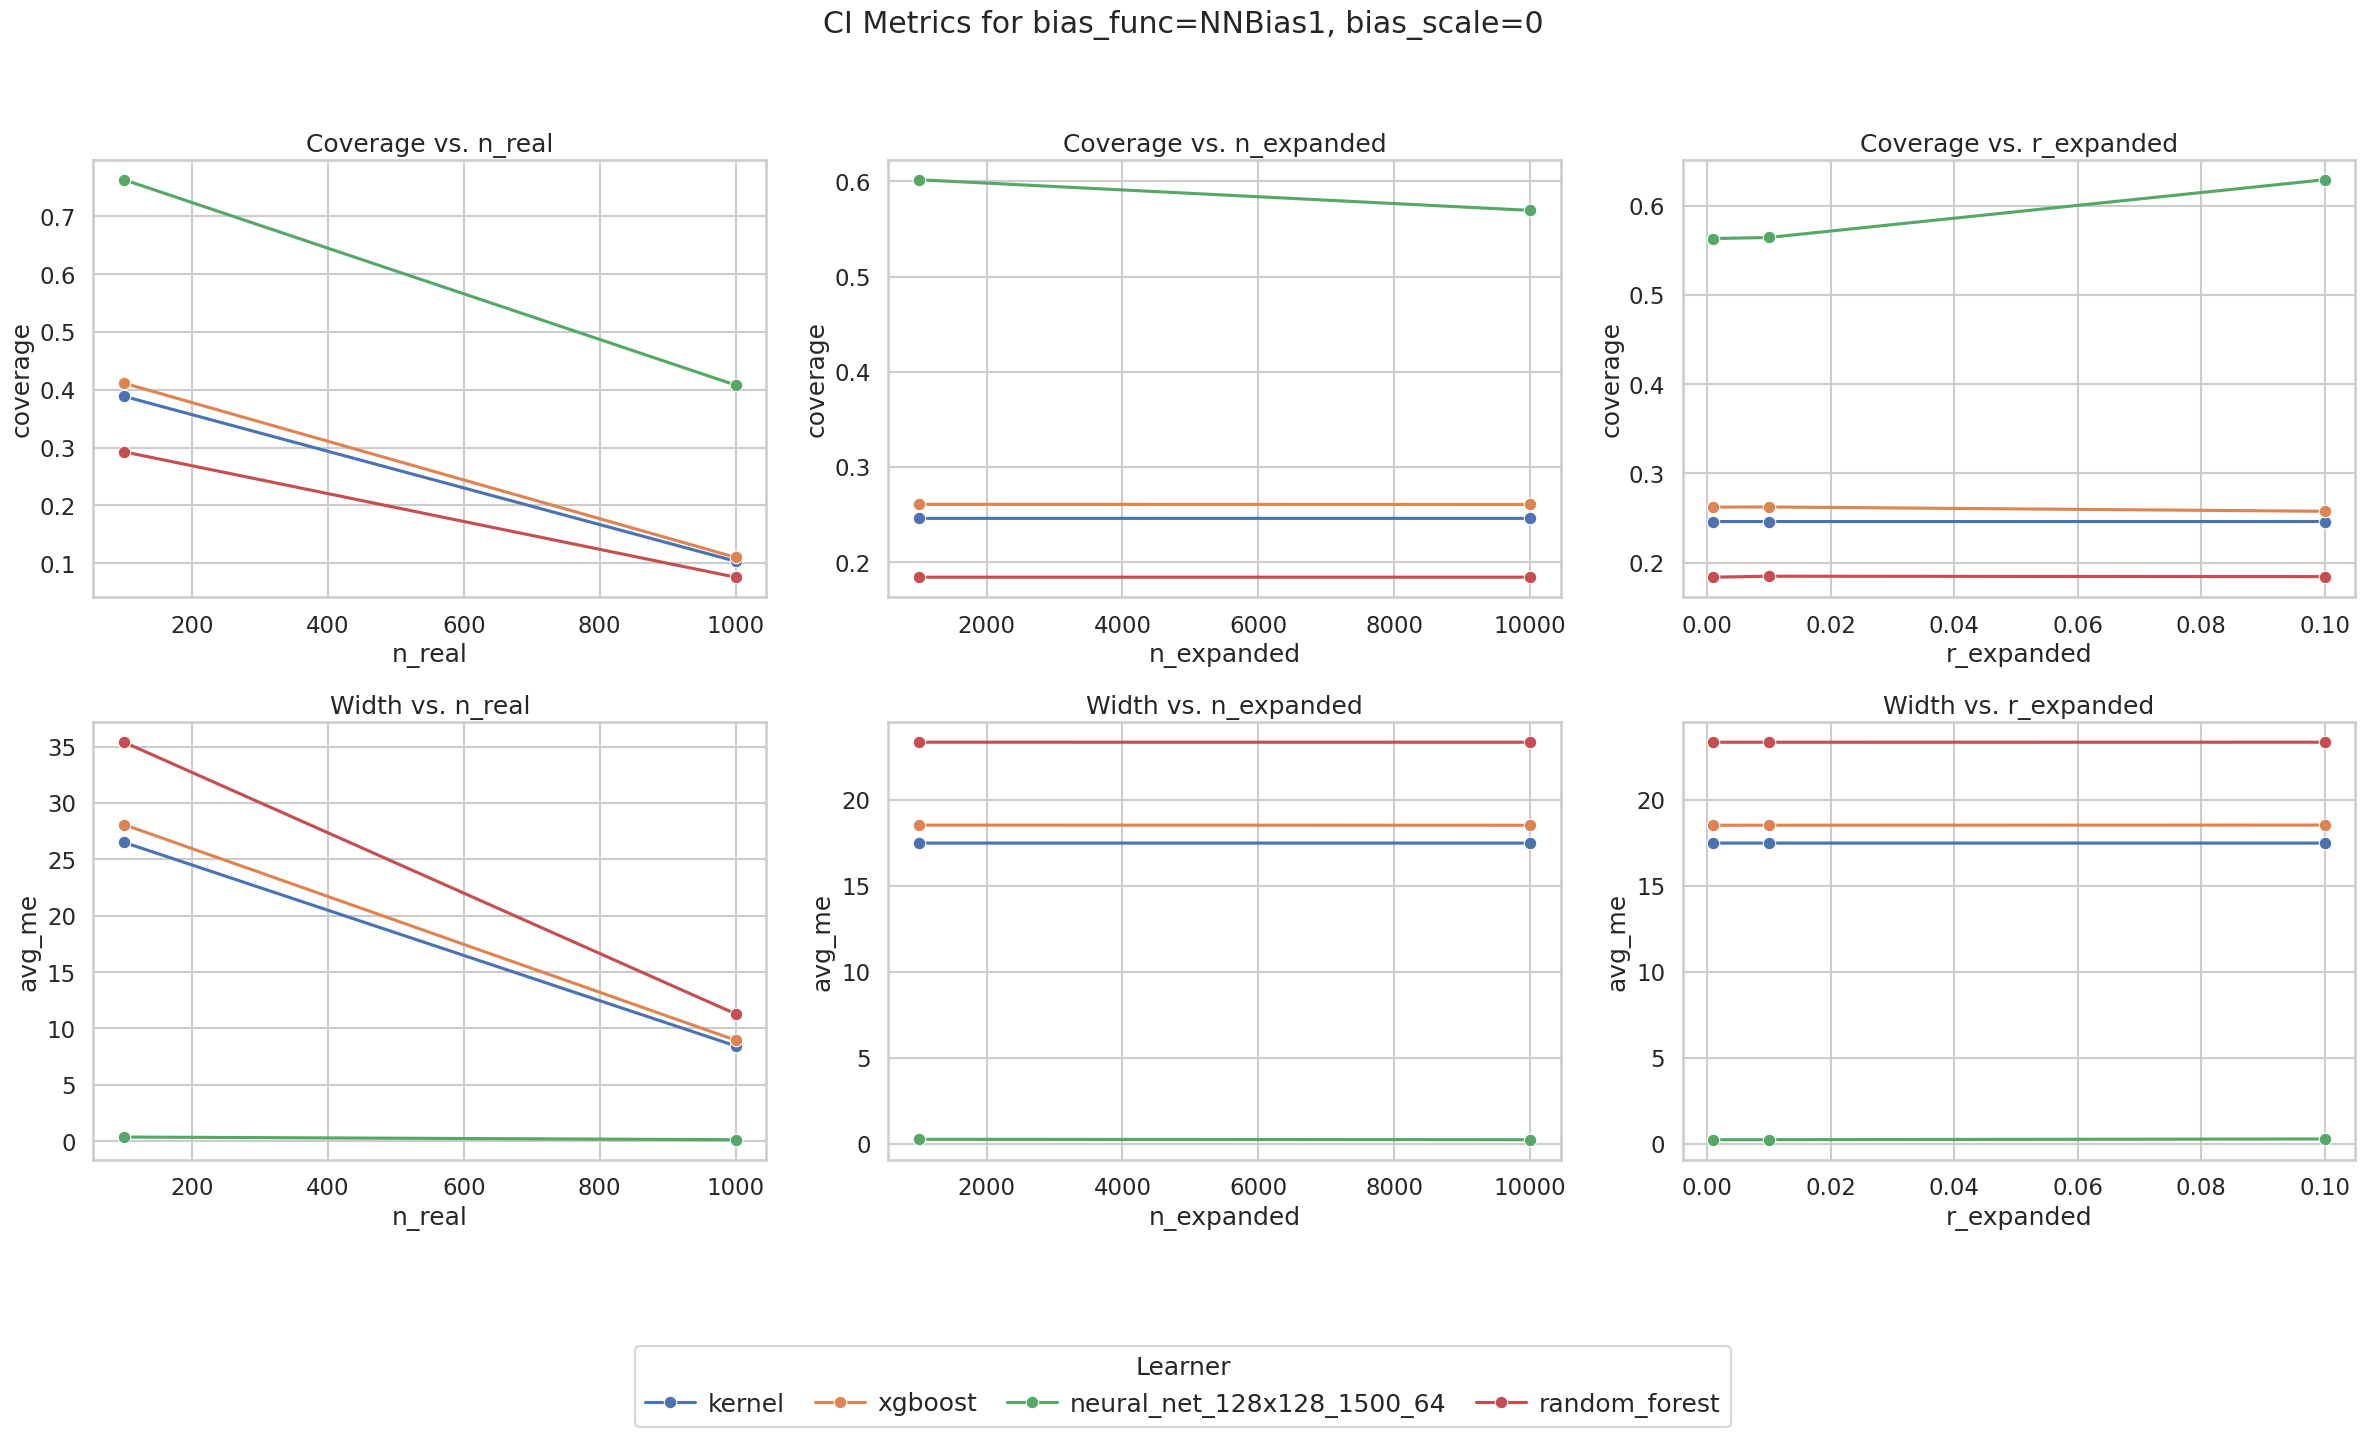

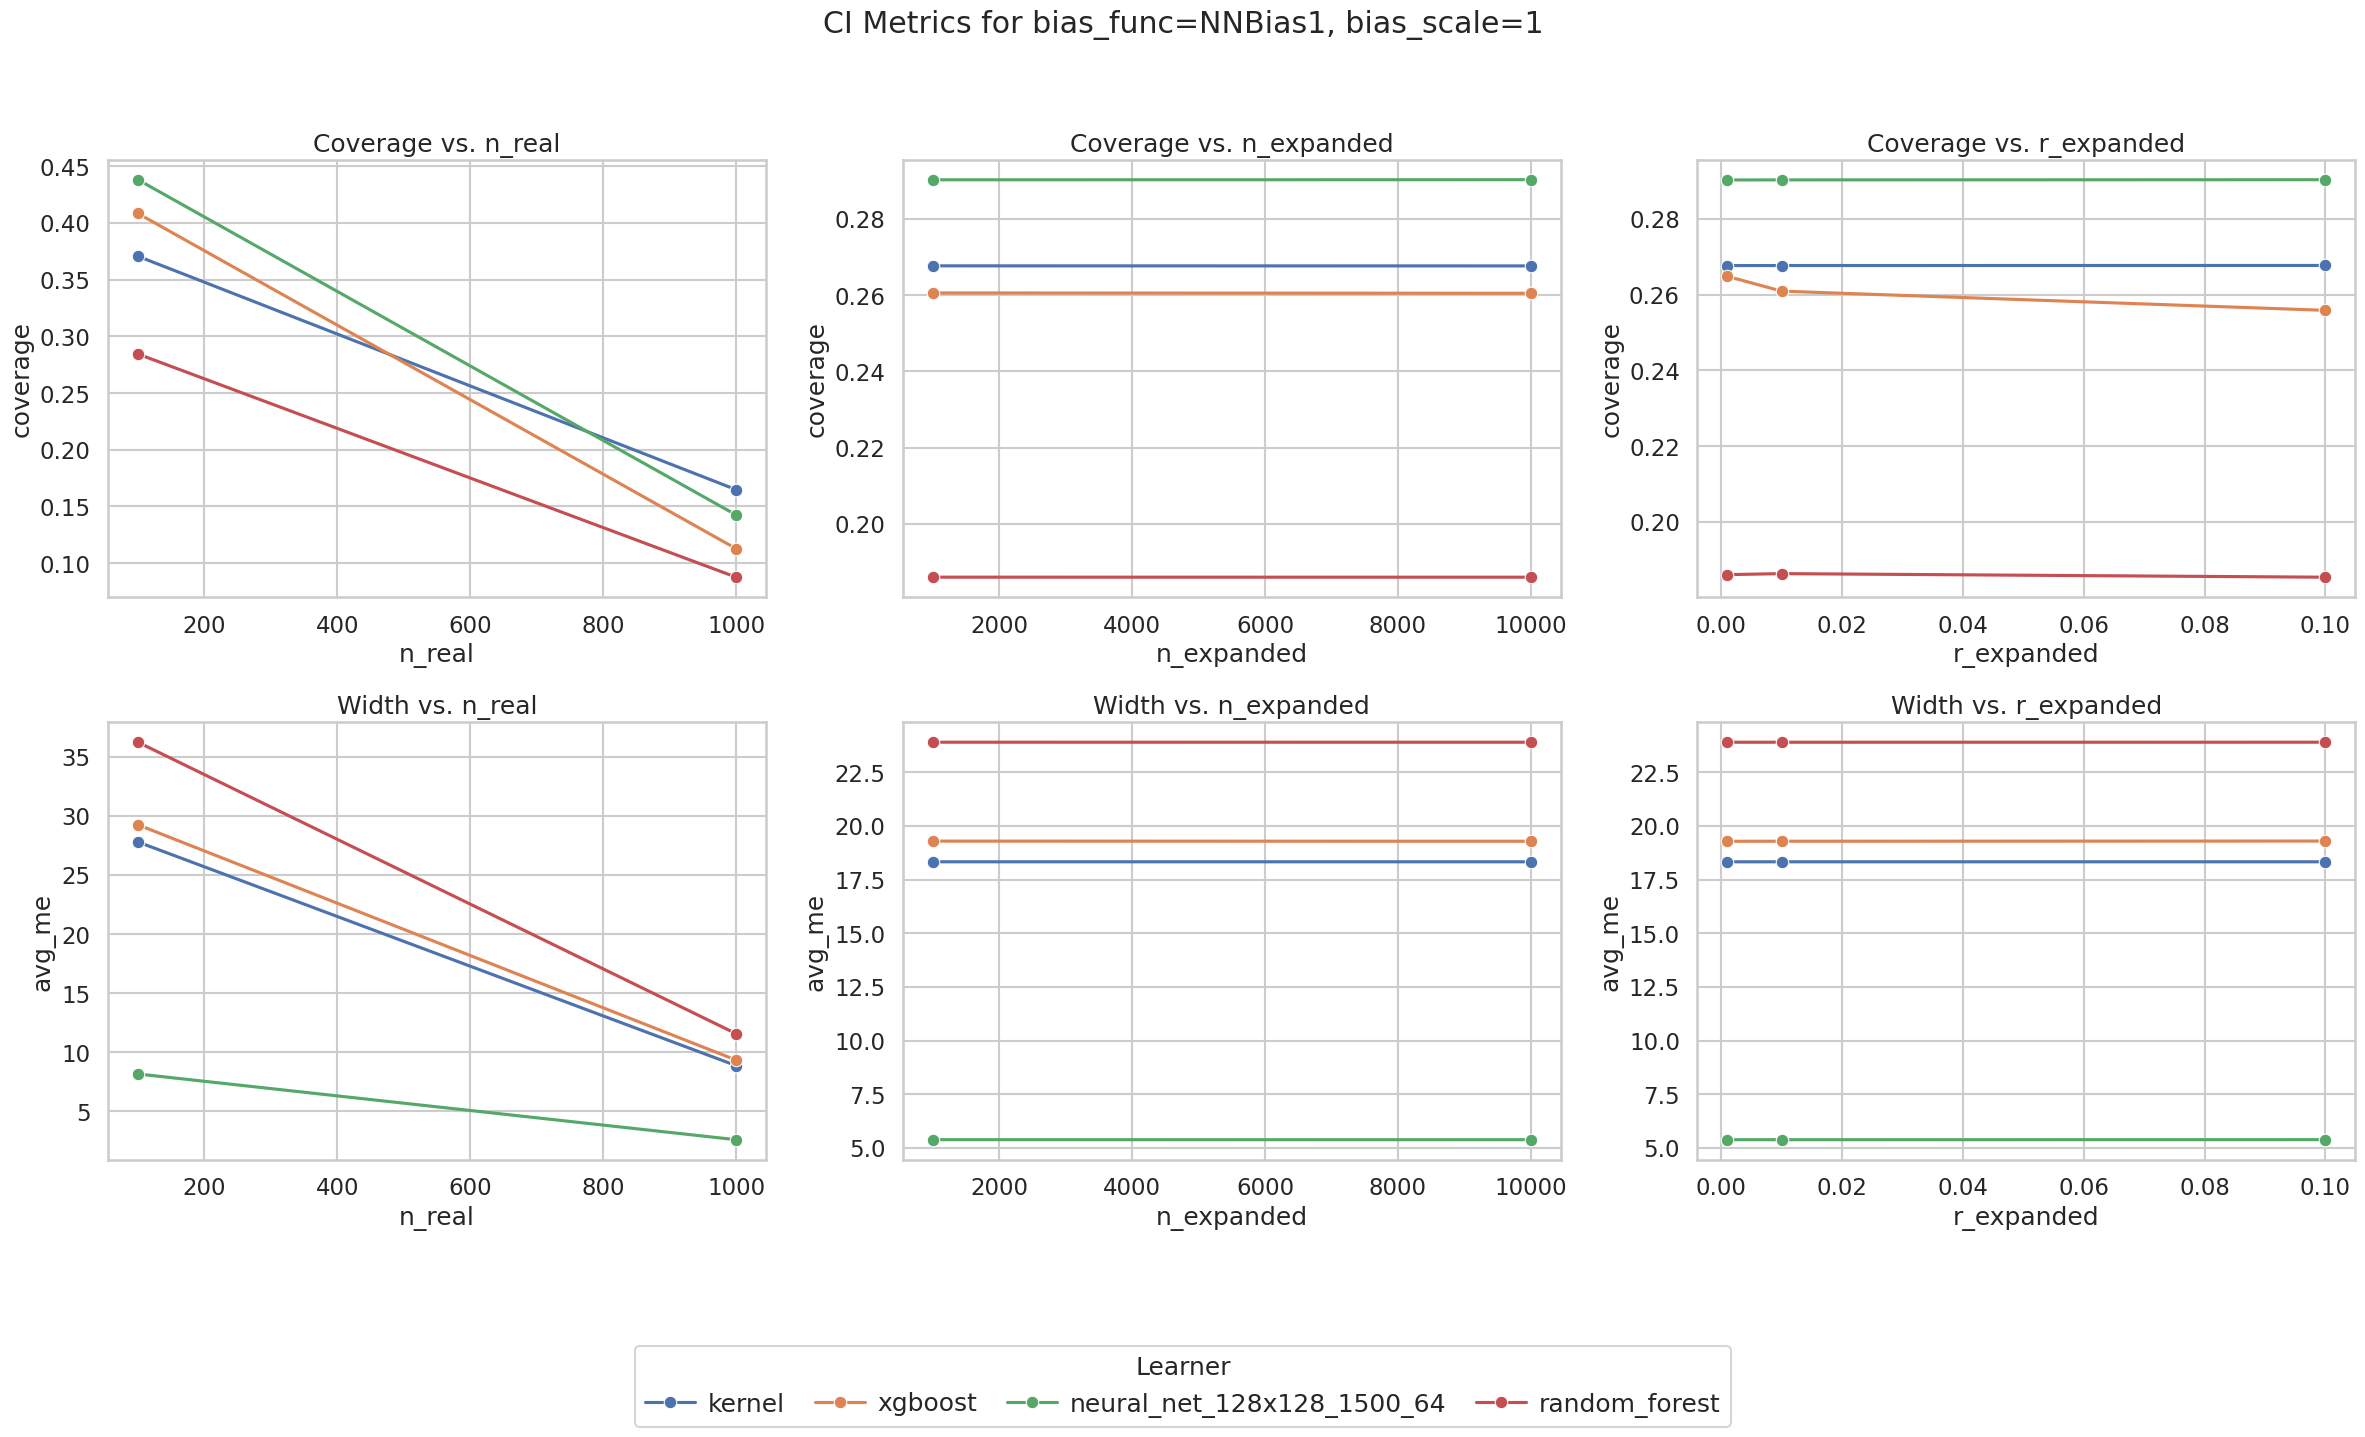

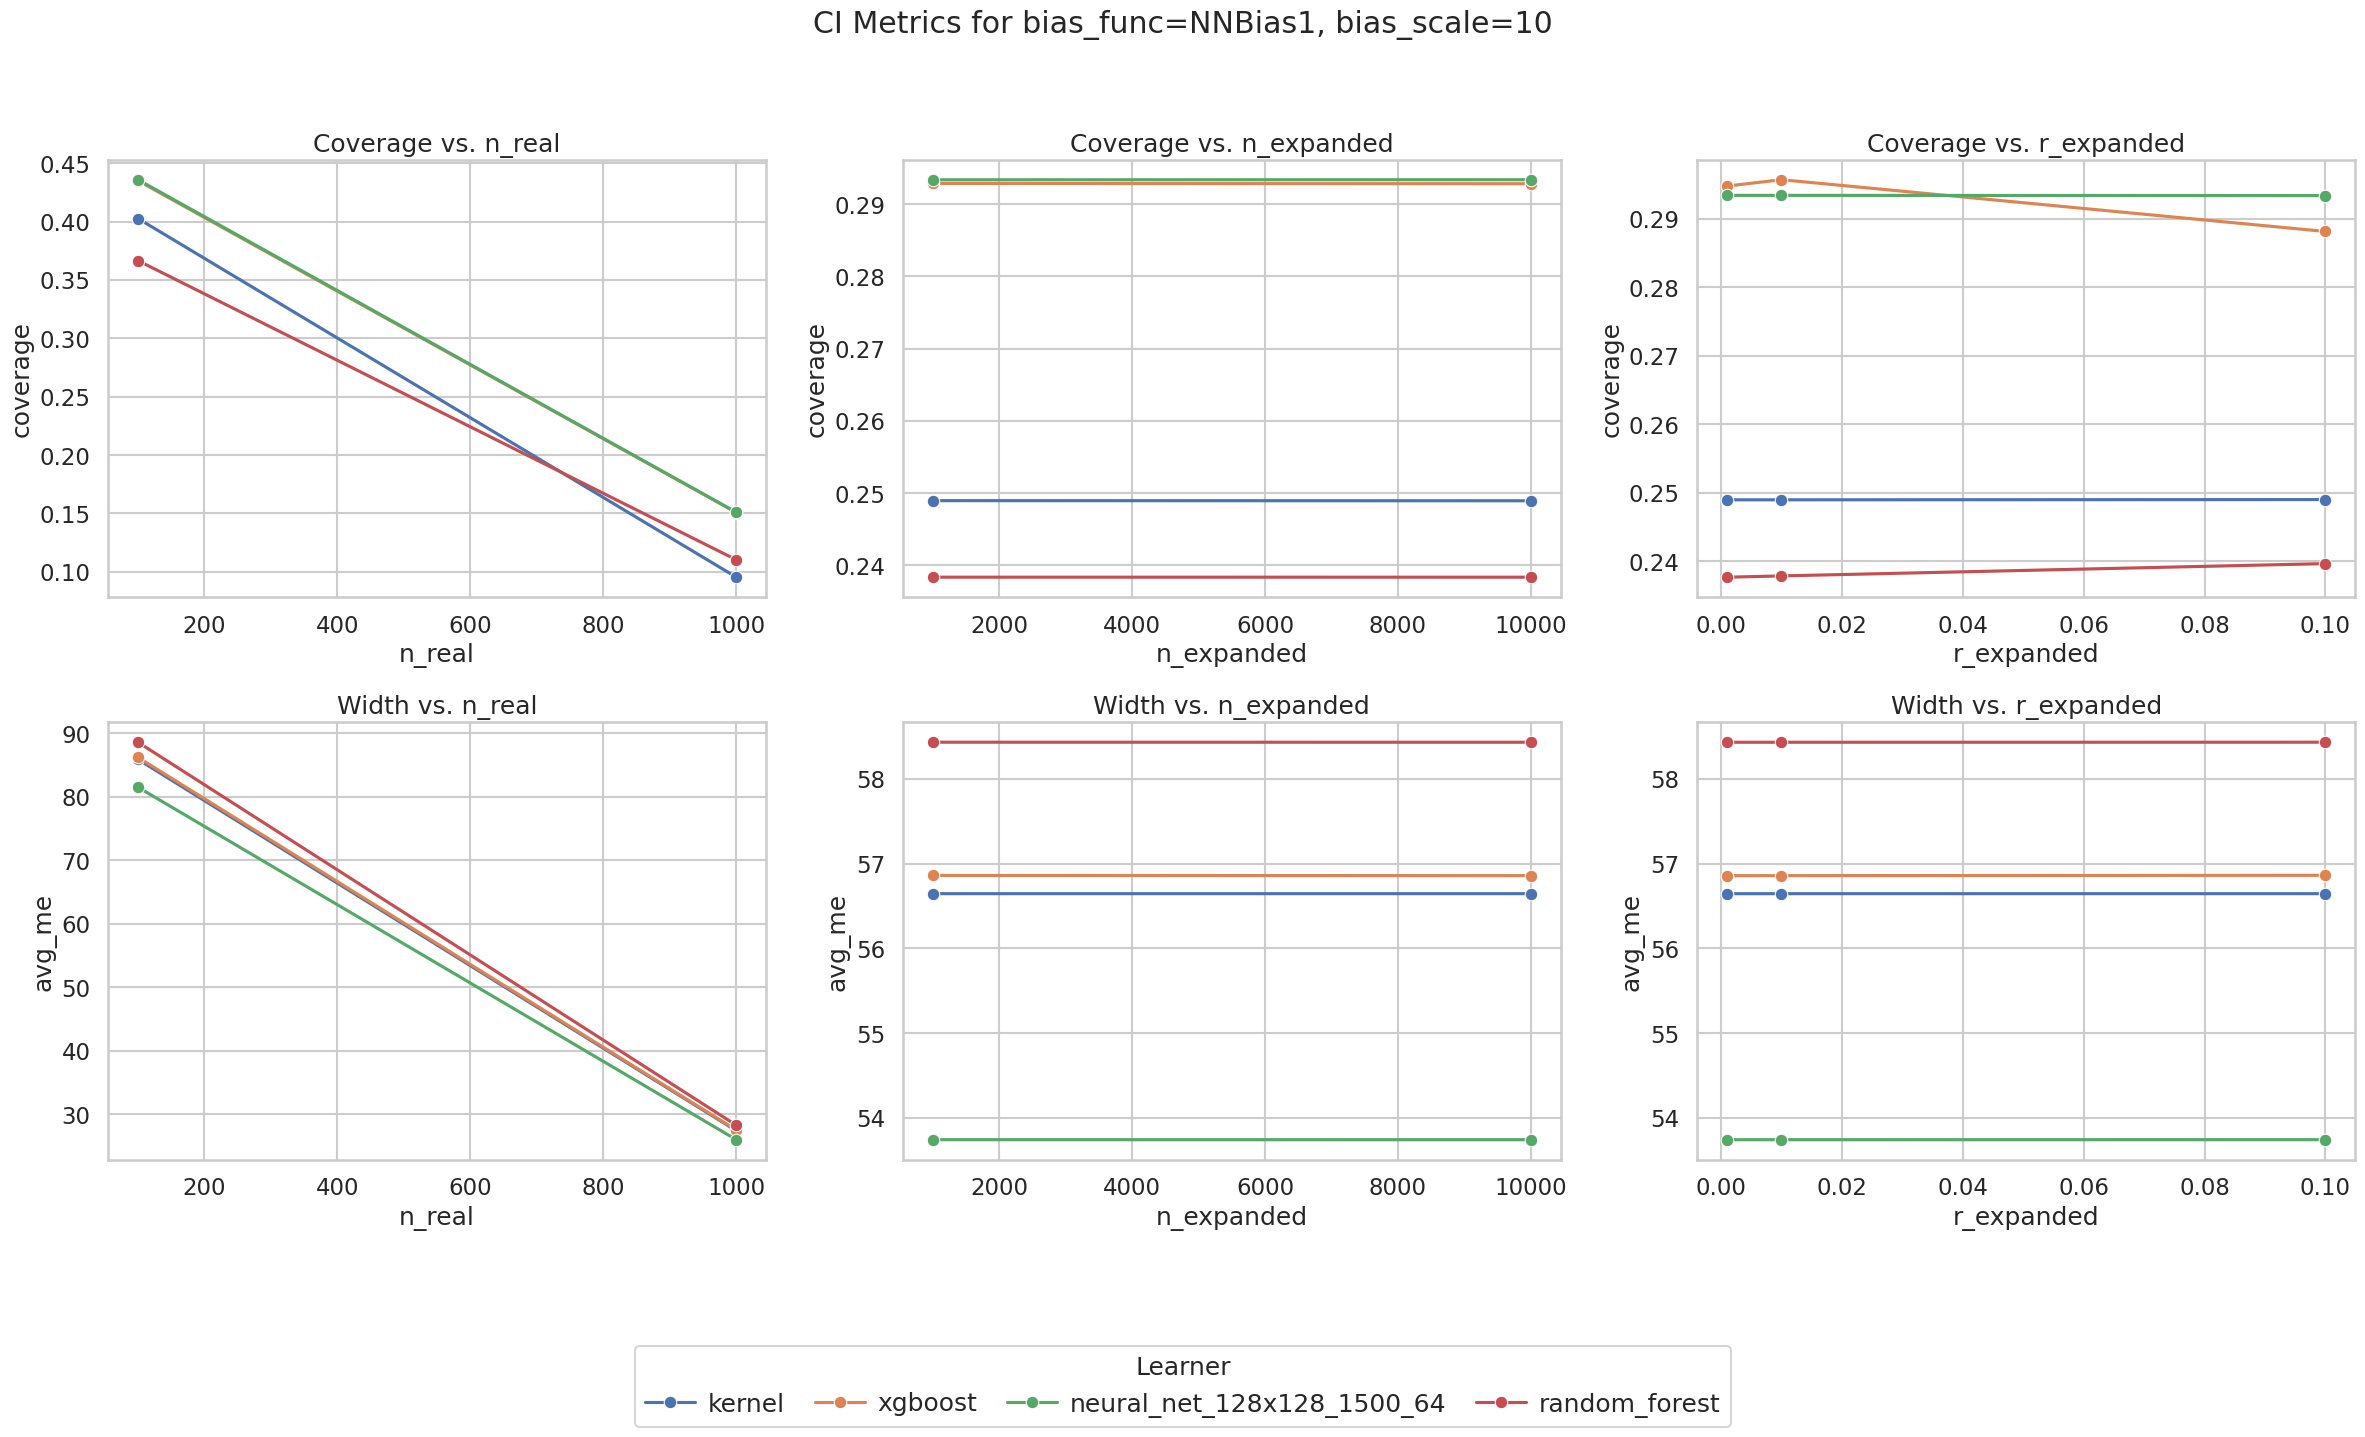

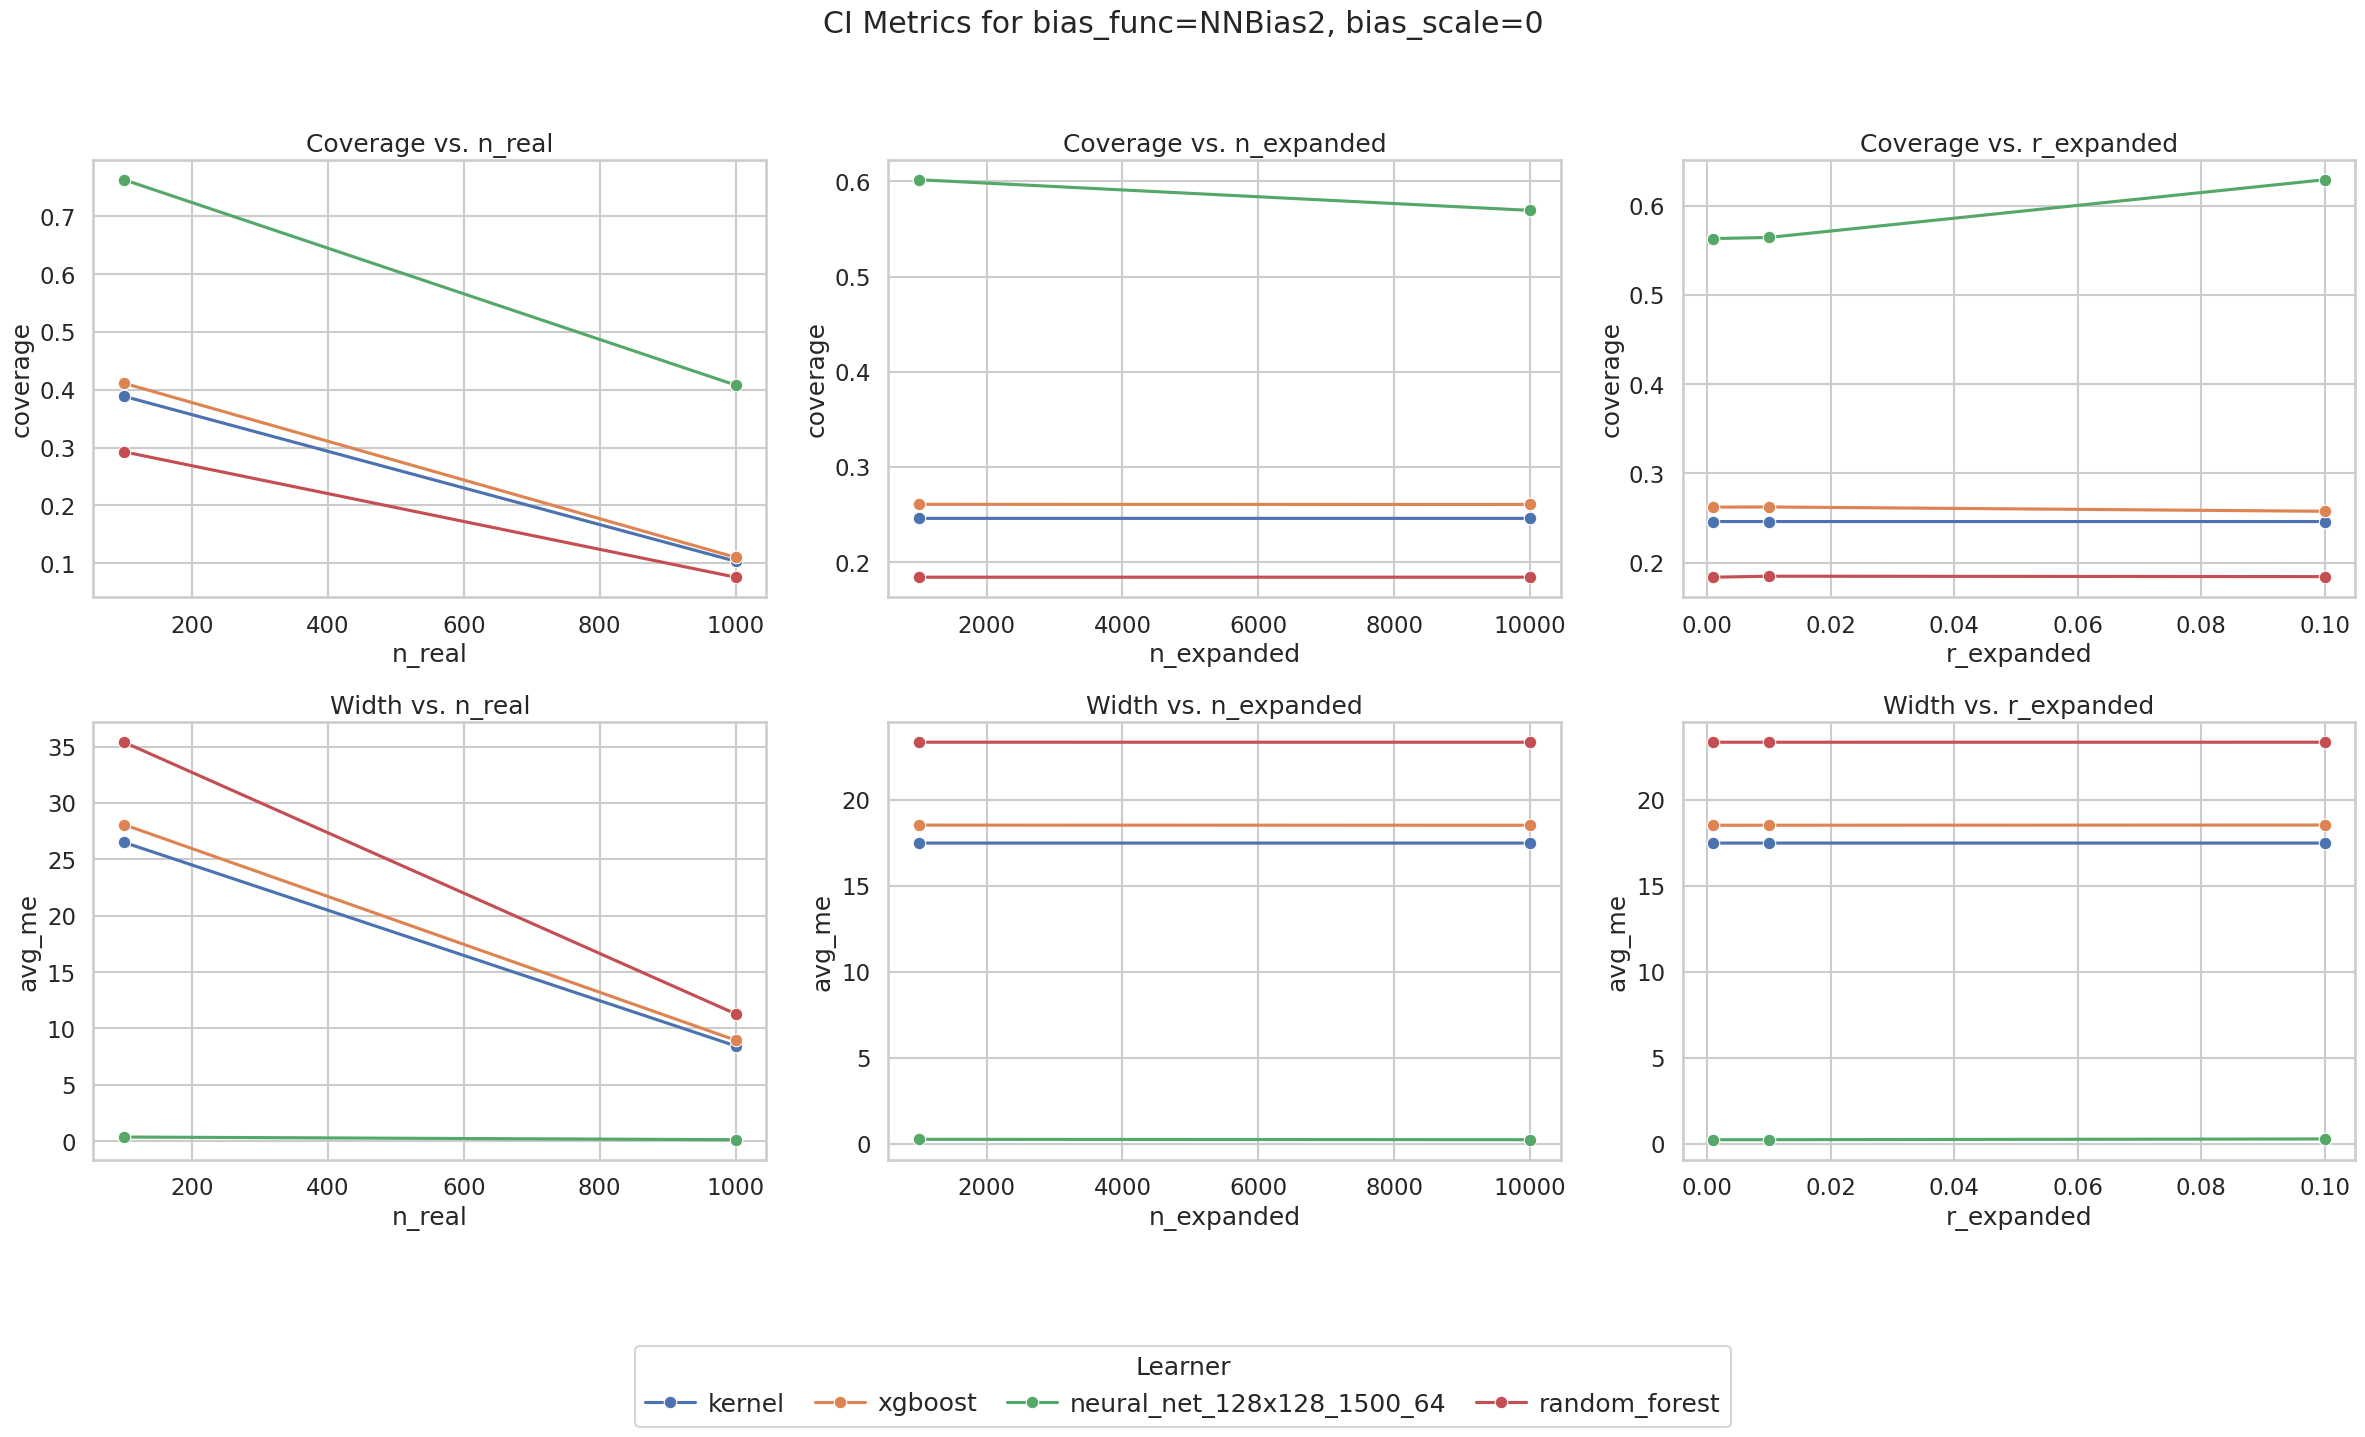

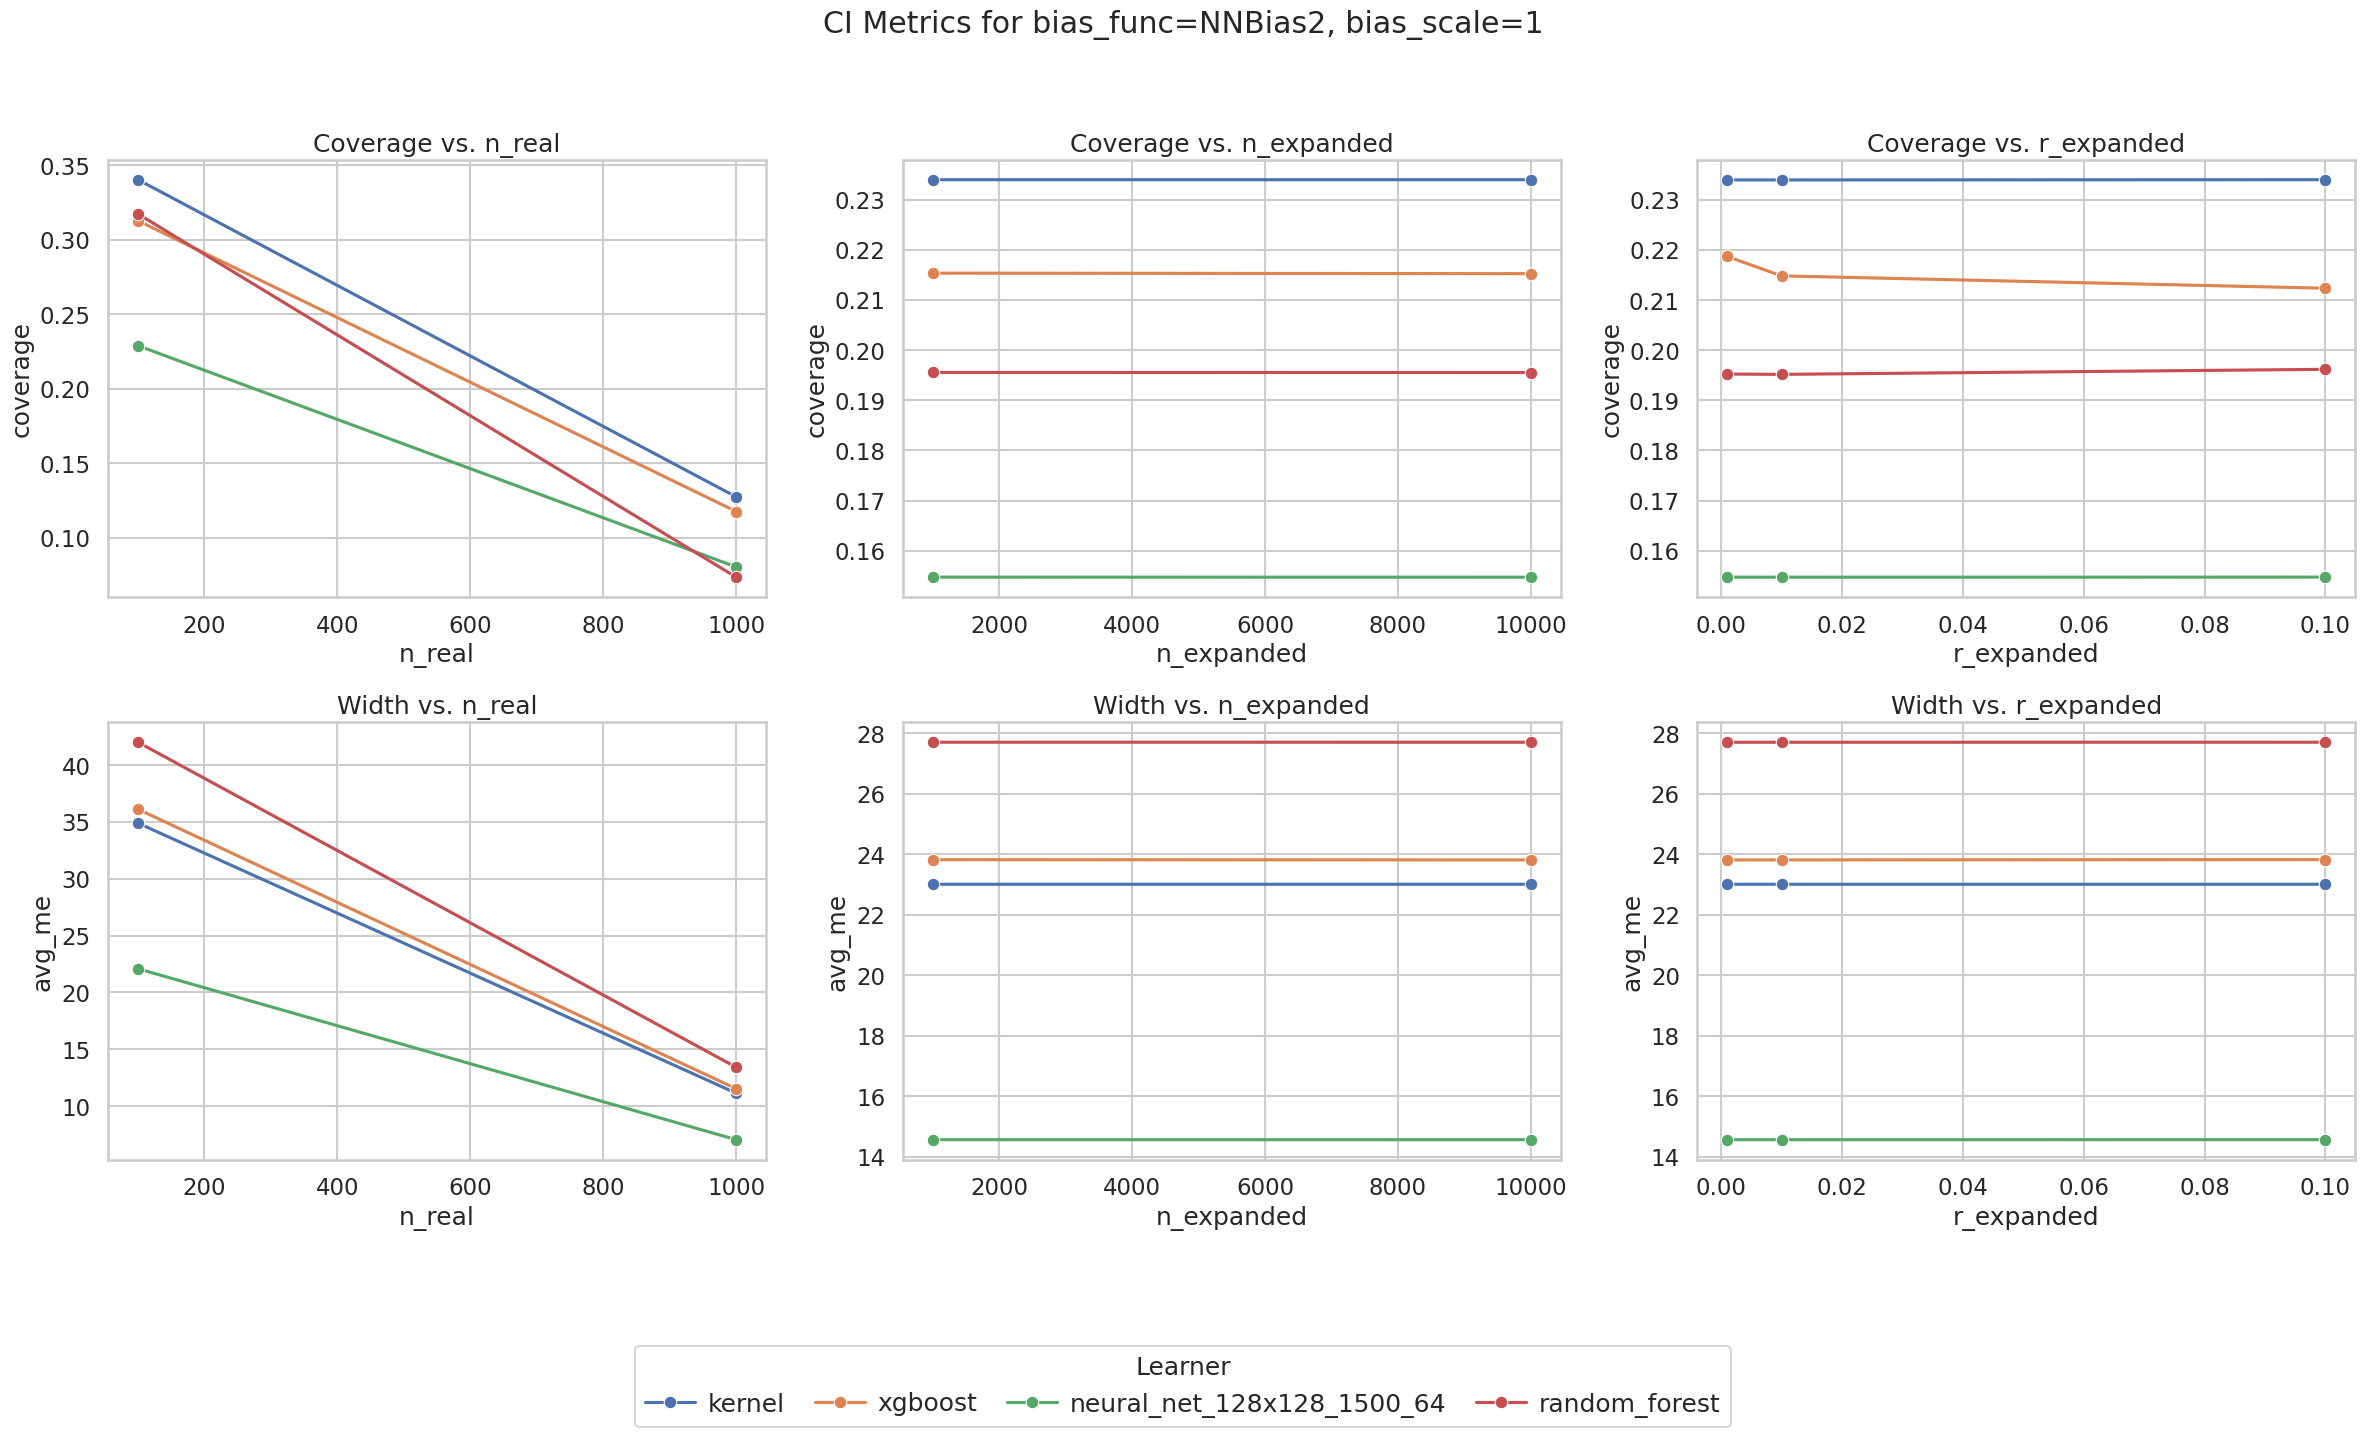

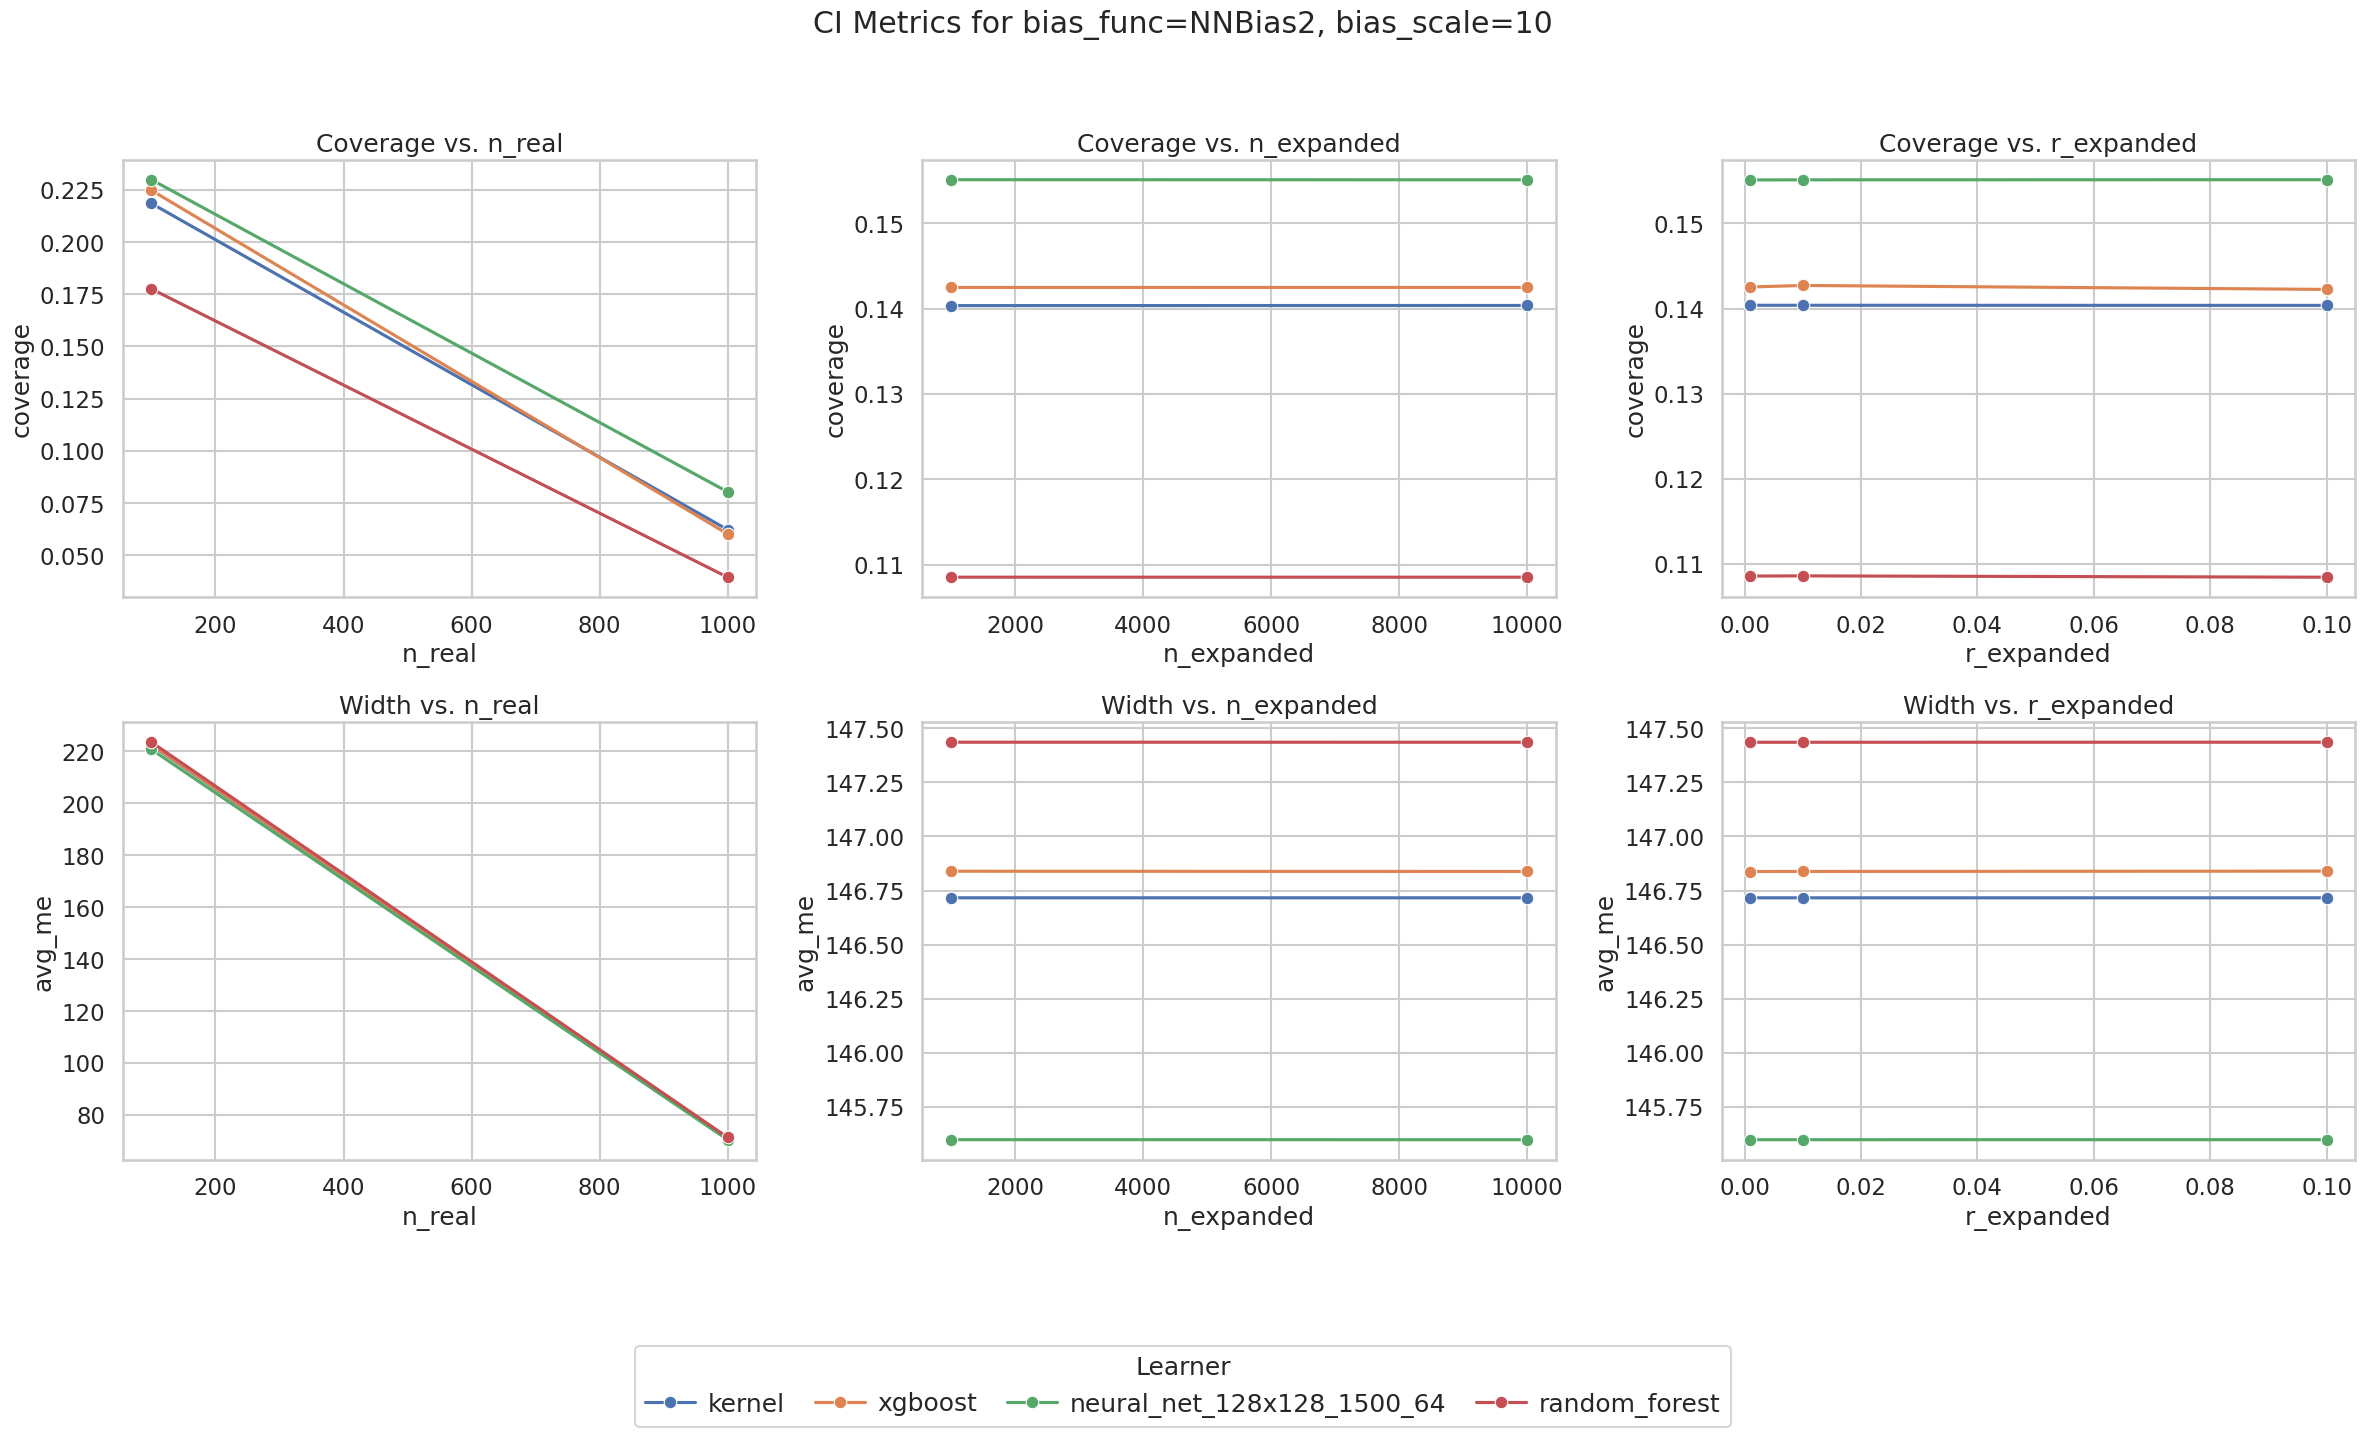

In [15]:
plot_CI_by_conditions(results, save_dir="/home/yqg36_g_ucla_edu/Mediation/plots", dpi=300)